Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Нам предстоит изучить:

- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

* [Подготовка данных](#подготовка)
* [Продуктовые метрики](#метрики)
   * [Рассчет DAU, WAU и MAU](#дау)
   * [Сколько раз за день пользователи в среднем заходят на сайт](#визитс) 
   * [Продолжительность типичной пользовательской сессии](#продолжительность)
   * [Расчёт Retention Rate](#возврат)
* [Метрики электронной коммерции](#метрики_эл)
   * [Время с момента первого посещения сайта до совершения покупки](#покупка)
   * [Среднее количество покупок на одного покупателя за 6 месяцев](#покупка_юзер)
   * [LTV на покупателя по когортам. ](#лтв)
* [Маркетинговые метрики](#маркетинг)
   * [Сумма всех расходов на маркетинг](#расходы)
   * [Рассчет среднего САС](#расходы_ист)
   * [ROMI по когортам.](#роми)
   * [ROMI для источников по месяцам](#роми_ист)
* [Выводы](#выводы)
  * [Источники трафика, на которые маркетологам стоит делать упор. ](#вывод_источник)
  * [Выводы,после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции ](#вывод_маркетинг)
  * [Итоги когортного анализа. Самые перспективные для компании когорты клиентов¶ ](#вывод_когорты)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
warnings.filterwarnings('ignore')

# Подготовка данных к анализу  <a class="вывод" id="подготовка"></a>

In [2]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv')

In [3]:
display(visits.head())
display(orders.head())
display(costs.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [4]:
dataset = {
    'visits': visits,
    'orders': orders,
    'costs': costs
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))
    print(f'{x}: {y.isnull().any().any()}')
    
#проверяем на ненулевые значения - все чисто

visits [359400, 5]
visits: False
orders [50415, 3]
orders: False
costs [2542, 3]
costs: False


In [5]:
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

visits ['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']

orders ['Buy Ts', 'Revenue', 'Uid']

costs ['source_id', 'dt', 'costs']



In [6]:
#проверка на дубликаты и нулевые значения
print("visits:", visits.duplicated().any(), visits.isnull().any().any(), visits.info())
print()
print("costs:",costs.duplicated().any(), costs.isnull().any().any(), costs.info())
print()
print("orders:", orders.duplicated().any(), orders.isnull().any().any(), orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
visits: False False None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
costs: False False None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Nu

VISITS:
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии, 
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

ORDERS:
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

COSTS:
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

In [7]:
#пишу фунуцию для графиков изменения метрик во времени 
def plt_graph(df, title, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(df, color = '#86bf91', zorder=2,  marker = '.', linewidth = '5')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show();

In [8]:
def plot_graph(df, set_xlabel, set_ylabel, size):
    x = df
    ax = x.plot(kind='barh', figsize=size, color='#86bf91', zorder=2, width=0.85)

    vals = ax.get_xticks()
    for tick in vals:
          ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#eeeeee', zorder=1)
    ax.set_xlabel(set_xlabel, labelpad=20, weight='bold', size=12)
    ax.set_ylabel(set_ylabel, labelpad=20, weight='bold', size=12);

In [9]:
pal = sns.color_palette("Blues")

# Продуктовые метрики <a class="вывод" id="метрики"></a>

# Рассчет DAU, WAU и MAU. <a class="вывод" id="дау"></a>

In [10]:
visits.columns =visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
# меняю регистр имен колонок 


visits=visits.rename(columns={"start ts": "start_ts", "end ts": "end_ts", "source id": "source_id"})
orders=orders.rename(columns={"buy ts": "order_data"})
#меняю имена start ts, end ts и buy ts, чтобы к ним было цдобнее обращаться
costs.dt = pd.to_datetime(costs.dt)

date_columns = ['start_ts', 'end_ts']
for col in date_columns:
    visits[col] = pd.to_datetime(visits[col], format='%Y-%m-%d %H:%M:%S')

orders['order_data'] = pd.to_datetime(orders['order_data'])
#меняю дату методомо datetime 

Изучим данные пользовательской активности

подготовка данных для рассчета dau, mau и wau

In [11]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_day']  = visits['start_ts'].dt.day

visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,27


- DAU (от англ. daily active users) — количество уникальных пользователей в день;
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

In [12]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).mean()

print('количество уникальных пользователей в день за весь период:', int(dau_total))
print('количество уникальных пользователей в неделю за весь период:', int(wau_total))
print('количество уникальных пользователей в месяц за весь период:', int(mau_total))

количество уникальных пользователей в день за весь период: 907
количество уникальных пользователей в неделю за весь период: 5716
количество уникальных пользователей в месяц за весь период: 23228


In [13]:
sticky_mau = (dau_total/mau_total) * 100
sticky_wau = (dau_total/wau_total) * 100
print('соотношение пользователей в день к недельной аудитории {0:.2f}'.format(float(sticky_wau)))
print('соотношение пользователей в день к месячной аудитории {0:.2f}'.format(float(sticky_mau)))

соотношение пользователей в день к недельной аудитории 15.88
соотношение пользователей в день к месячной аудитории 3.91


Как мы видим, количество активных посеителей сайта за весь период больше 23 тыс уникальных пользователей за месяц и 907 за день

In [14]:
visits_per_day = visits.groupby('session_date')['uid'].nunique()
visits_per_week = visits.groupby('session_week')['uid'].nunique()
visits_per_month = visits.groupby('session_month').agg({'uid': 'nunique'})

In [15]:
visit_metrics = visits.set_index(['start_ts'])
def plot_metics(resample):
    dau = visit_metrics.resample(resample).uid.nunique()
    dau_total = visit_metrics.resample('D').uid.nunique().mean()

    dau.plot(figsize=(15,7), legend=False, grid=True, title='Динамика за весь период');
    plt.xlabel('Дата');

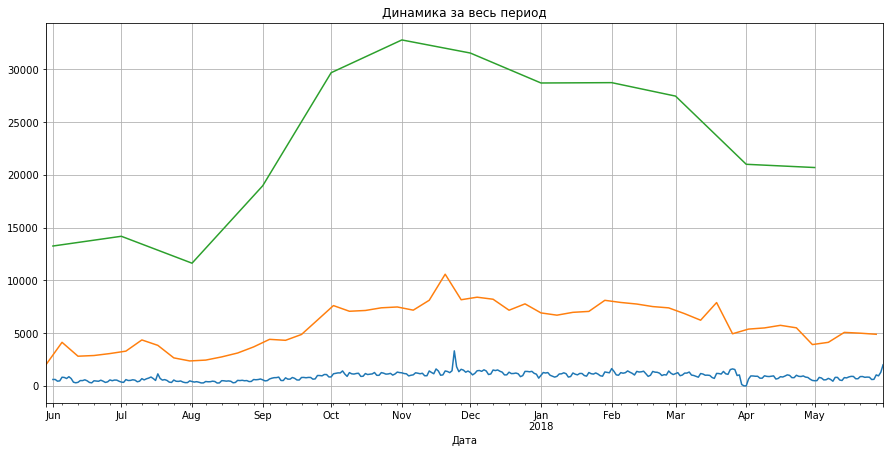

In [16]:
plot_metics('D')
plot_metics('W')
plot_metics('M')

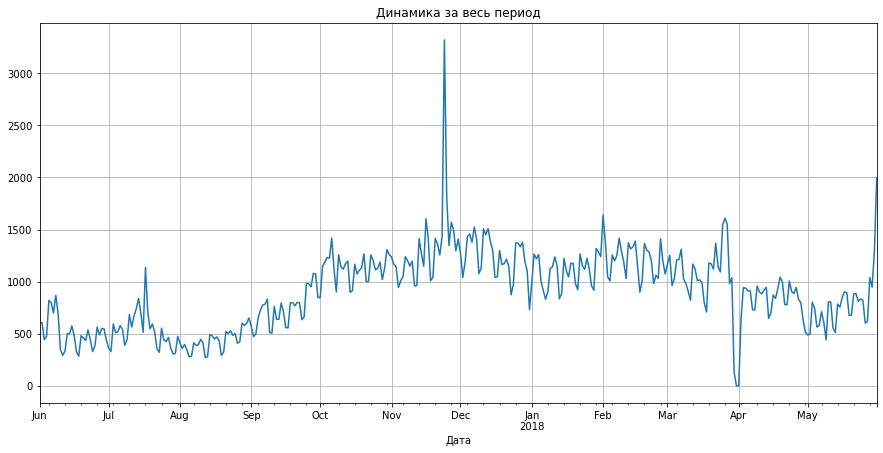

In [17]:
plot_metics('D')

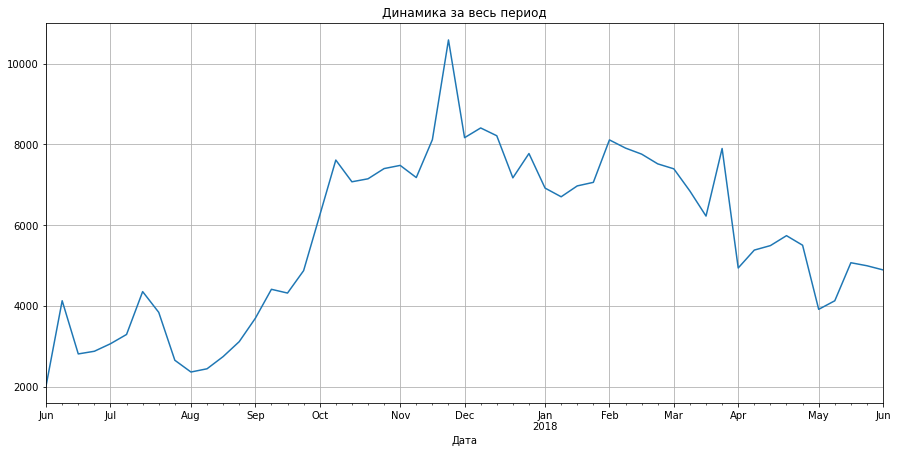

In [18]:
plot_metics('W')

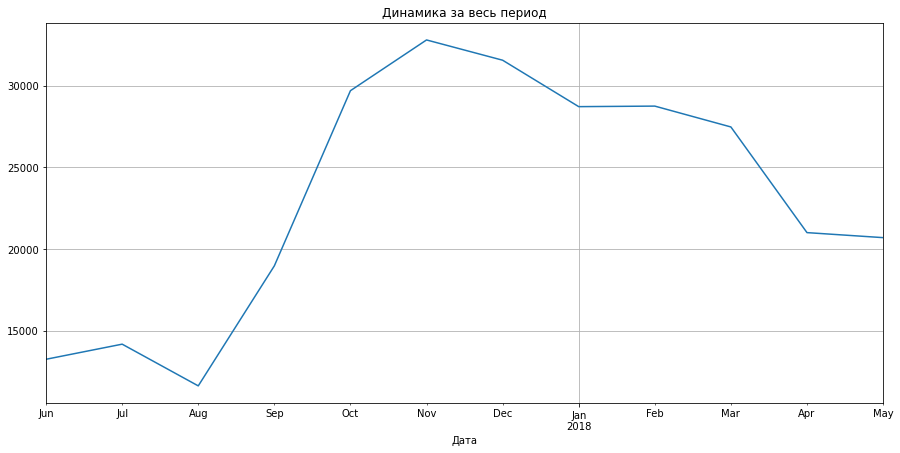

In [19]:
plot_metics('M')

In [20]:
visits.groupby('session_date').agg({'uid': 'nunique'}).max()
#в какой-то день у нас было 3319  уникальных пользователей! По сравненпю с 907 в среднем - колосальная разница.

uid    3319
dtype: int64

In [21]:
visits_max = visits.groupby('session_date').agg({'uid': 'nunique'})
visits_max[visits_max['uid'] == 3319]

,uid
session_date,
2017-11-24,3319


Максимум уникальныз пользователей на день приходится на 24 декабря  2017-ого. можно предполодить, что дело в новогодниз праздниках или кристмасею. Максимум уникальныз пользователей на неделю приходится на 47-ую неделю - лето 2018. Рещко падаает с 25-ой по 32 недели.

Как мы видим, количество уникальных пользователей в день за весь период: 907,
количество уникальных пользователей в неделю за весь период: 5716,
количество уникальных пользователей в месяц за весь период: 23228.
    
Больше всего клиентов у нас было в ноябре, меньше всего летом. Вероятно, клиенты были в отпуске и были заняты другими делами.Также максимальная активность за день прослеживается в середине периода - у нас было 3319  уникальных пользователей yf  по дате 2017-11-24 По сравненпю с 907 в среднем - колосальная разница.

# Сколько раз за день пользователи в среднем заходят на сайт <a class="вывод" id="визитс"></a>

In [22]:
session_per_day = visits.groupby('session_date').agg({'uid': ('count', 'nunique')})
session_per_day.columns = ['n_sessions', 'n_users']
session_per_day['sess_per_user'] = (session_per_day['n_sessions']/session_per_day['n_users']).astype(float)
session_per_day.head()

,n_sessions,n_users,sess_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [23]:
session_per_day_graph = session_per_day.groupby('session_date').agg({'sess_per_user' : 'sum'})
display(session_per_day_graph.head(5))

,sess_per_user
session_date,
2017-06-01,1.097521
2017-06-02,1.082237
2017-06-03,1.071910
2017-06-04,1.071429
2017-06-05,1.089024


In [24]:
print(session_per_day.mean())
print(session_per_day.max())

n_sessions       987.362637
n_users          907.991758
sess_per_user      1.082170
dtype: float64
n_sessions       4042.000000
n_users          3319.000000
sess_per_user       1.217837
dtype: float64


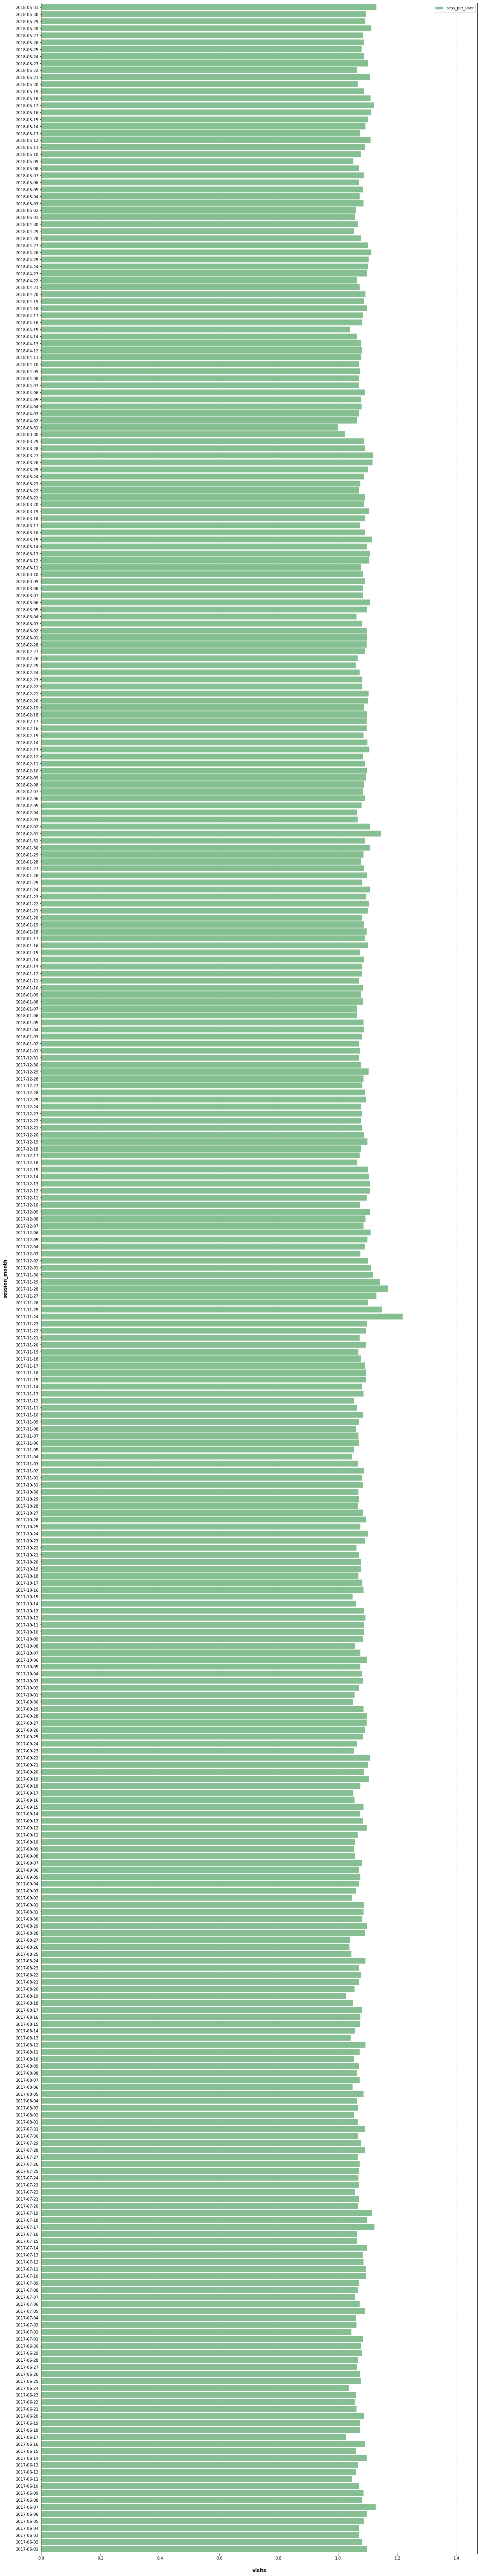

In [25]:
size = (20, 120)
df = session_per_day.groupby('session_date').agg({'sess_per_user': 'sum'})
plot_graph(df, 'visits', 'session_month', size)

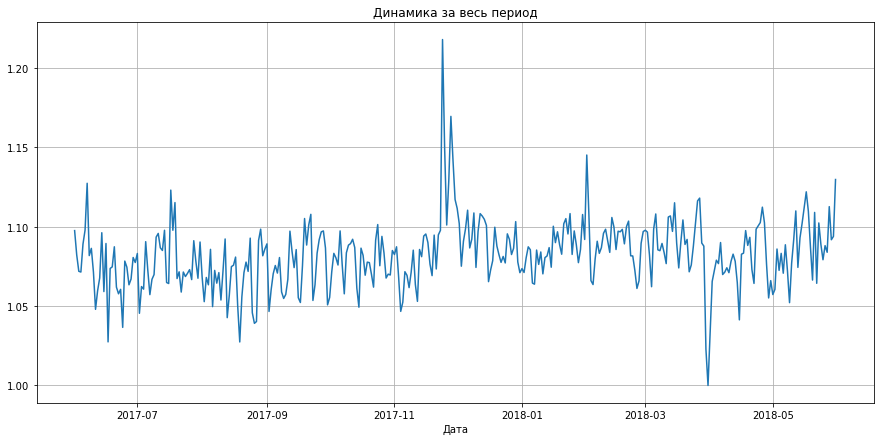

In [26]:
session_per_day_graph.plot(figsize=(15,7), legend=False, grid=True, title='Динамика за весь период');
plt.xlabel('Дата');

В день один пользователь в среднем проводит в приложении максимум 1 сессию. Не сказать, что продукт используется регулярно.
В среднем на сайте обрабатывается 987 сессий и песещает 907 человек в день. Даже с максимум сессий в день - 4042 и 3319 пользователей сессия в день не превышает 1. Максимум сессий призодится на 24 декабря - можно предполодить, что дело в новогодниз праздниках или кристмасе

# Продолжительность типичной пользовательской сессии <a class="вывод" id="продолжительность"></a>

In [27]:
visits['ASL'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds

visit_non_null = visits[visits['ASL'] > 0]
visit_non_null

visits_device_touch = visit_non_null[visit_non_null['device'] == 'touch']
visits_device_desktop = visit_non_null[visit_non_null['device'] == 'desktop']

Изучим средняя продолжительность сессии или ASL (англ. average session length). Она показывает, сколько длится сессия пользователя в среднем.

In [28]:
visit_non_null['ASL'] = (
    visit_non_null['end_ts'] - visit_non_null['start_ts']
).dt.seconds
print('средняя продолжительность сессии: ',visit_non_null['ASL'].mean()) 

#средняя продолжительность сессии у нас 643 секунды
visits_device_touch['ASL'] = (
    visits_device_touch['end_ts'] - visits_device_touch['start_ts']
).dt.seconds
touch_visits_durations = visits_device_touch['ASL']
print('средняя продолжительность сессии для теелфона: ',touch_visits_durations.mean())

visits_device_desktop['ASL'] = (
    visits_device_desktop['end_ts'] - visits_device_desktop['start_ts']
).dt.seconds

desctop_visits_durations = visits_device_desktop['ASL']

print('средняя продолжительность сессии для компьютера: ',desctop_visits_durations.mean()) 

средняя продолжительность сессии:  714.684622658418
средняя продолжительность сессии для теелфона:  548.1421253894816
средняя продолжительность сессии для компьютера:  773.7558335217141


<AxesSubplot:>

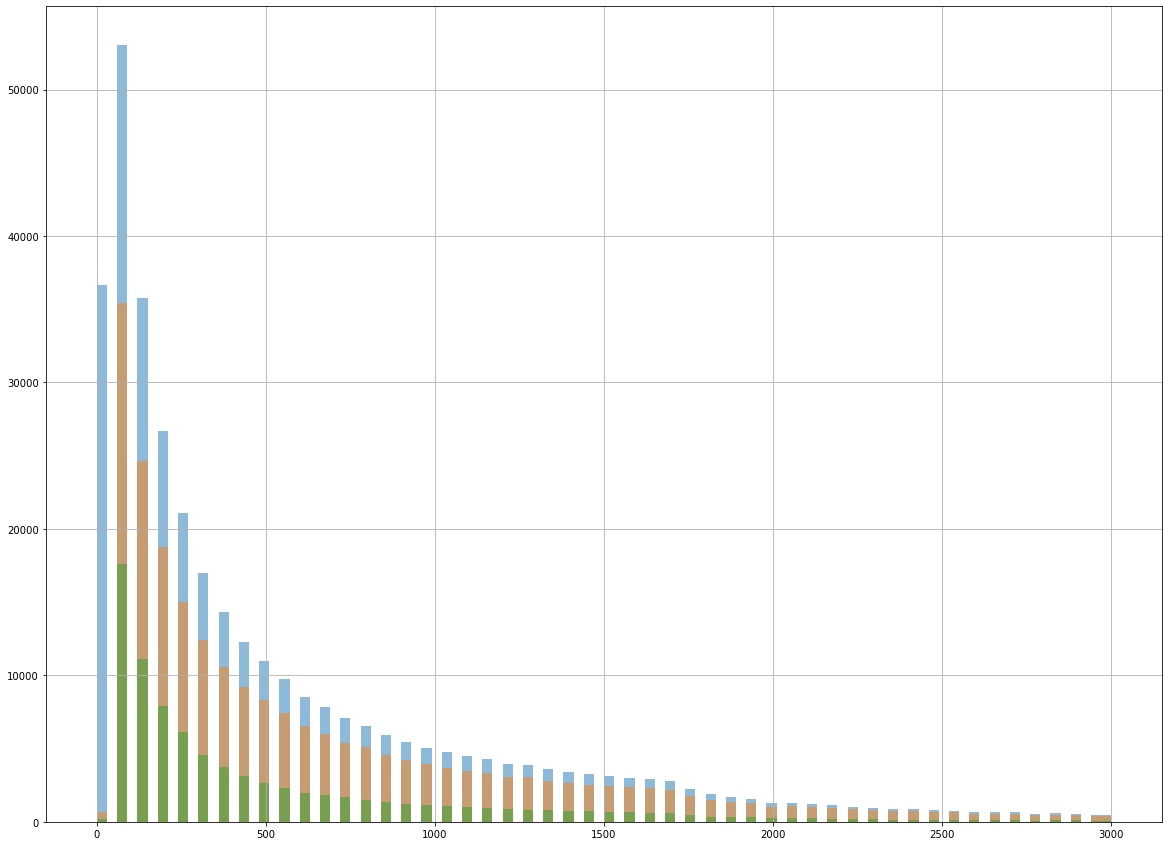

In [29]:
visits['ASL'].hist(bins=100, figsize=(20,15), alpha = 0.5, range = (0, 3000))
visits_device_desktop['ASL'].hist(bins=100, figsize=(20,15), alpha = 0.5, range = (0, 3000)) 
visits_device_touch['ASL'].hist(bins=100, figsize=(20,15), alpha = 0.5, range = (0, 3000)) 

Это у нас Геометрическое распределение. 

In [30]:
print('самая частая продолжительность типичной пользовательской сессии {0} минута'.format((visits['ASL'].mode()[0] / 60)))
print('самая частая продолжительность типичной пользовательской сессии с компьютера {0} минута'.format((visits_device_desktop['ASL'].mode()[0] / 60)))
print('самая частая продолжительность типичной пользовательской сессии с телефона {0} минута'.format((visits_device_touch['ASL'].mode()[0] / 60)))

самая частая продолжительность типичной пользовательской сессии 1.0 минута
самая частая продолжительность типичной пользовательской сессии с компьютера 1.0 минута
самая частая продолжительность типичной пользовательской сессии с телефона 1.0 минута


In [31]:

print('средняя сессия с телефона: ', touch_visits_durations.mean())
print('средняя сессия за компьютером: ', desctop_visits_durations.mean())

print()

alpha = 0.05

results = st.ttest_ind(desctop_visits_durations, touch_visits_durations)

#print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, существует статистически значимое различие между средним временем посещений с телефона и компьютера")
else:
    print("Не получилось отвергнуть нулевую гипотезу, не существует статистически значимое различие между средним временем посещений с телефона и компьютера")

средняя сессия с телефона:  548.1421253894816
средняя сессия за компьютером:  773.7558335217141

Отвергаем нулевую гипотезу, существует статистически значимое различие между средним временем посещений с телефона и компьютера


Видим, что среднее кол-во сессий на клиента - одна в день, в день также заходят в среднем за весь период 5193 человека и совершают 5796 заказов. Максимальне количество сессий на клиента так же один раз в день на среднюю продолжительность 714 секунд. Это время различается в зависимости с какого утройства заходил пользователь - с телефона или с компьютера (548 секунд и 773 секугды соответсвенно - разница в практически два раза). 

Мы отвергли гипотезу о том, что не существует разницы между девайсами. Заставляет нас задуматься, что  версия сайта для телефона менее удобна, чем для пользвателя компьютера.

# Расчёт Retention Rate <a class="вывод" id="возврат"></a>

In [32]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_day,ASL
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,19,1680


In [33]:
visits['session_date'] = pd.to_datetime(visits['session_date'])
visits['session_week'] = pd.to_datetime(visits['session_week'])

In [34]:
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid') 

In [35]:
visits['activity_week'] = pd.to_datetime(
    visits['session_date'], unit='d'
) - pd.to_timedelta(visits['session_date'].dt.dayofweek, unit='d')

visits['first_activity_week'] = pd.to_datetime(
    visits['first_activity_date'], unit='d'
) - pd.to_timedelta(
    visits['first_activity_date'].dt.dayofweek, unit='d'
) 

In [36]:
visits['cohort_lifetime'] = (
    visits['activity_week'] - visits['first_activity_week']
)

visits['cohort_lifetime'] = visits[
    'cohort_lifetime'
] / np.timedelta64(1, 'W')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(
    'int'
) 

In [37]:
cohorts = visits.groupby(['first_activity_week','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [38]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_week', 'uid']
]
print(initial_users_count.head()) 

    first_activity_week   uid
0            2017-05-29  2021
53           2017-06-05  3944
105          2017-06-12  2567
156          2017-06-19  2585
206          2017-06-26  2717


In [39]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count.head()

,first_activity_week,cohort_users
0,2017-05-29,2021
53,2017-06-05,3944
105,2017-06-12,2567
156,2017-06-19,2585
206,2017-06-26,2717


In [40]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_week') 

In [41]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

In [42]:
print(cohorts.first_activity_week.min())

#выделяем второй месяц
cohorts_secomd_month = cohorts[cohorts['first_activity_week'] > '2017-07-1']
cohorts_secomd_month = cohorts_secomd_month[cohorts_secomd_month['first_activity_week'] < '2017-08-1']
cohorts_secomd_month = cohorts_secomd_month[cohorts_secomd_month['cohort_lifetime'] < 9]

2017-05-29 00:00:00


In [43]:
retention_pivot = cohorts_secomd_month.pivot_table(
    index='first_activity_week',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 
retention_pivot.loc['typical_cohort'] = retention_pivot.mean()
retention_pivot.loc['typical_cohort'] = retention_pivot.loc['typical_cohort'][retention_pivot.loc['typical_cohort'] != 1]
retention_pivot.head()

cohort_lifetime,0,1,2,3,4,5,6,7,8
first_activity_week,,,,,,,,,
2017-07-03 00:00:00,1.0,0.046600,0.028996,0.020021,0.013117,0.014843,0.013807,0.010356,0.013117
2017-07-10 00:00:00,1.0,0.038392,0.017380,0.013230,0.010376,0.011414,0.012711,0.011154,0.013748
2017-07-17 00:00:00,1.0,0.033780,0.024041,0.013999,0.016738,0.016433,0.015520,0.017955,0.015825
2017-07-24 00:00:00,1.0,0.024424,0.017051,0.018894,0.014747,0.017972,0.021198,0.014747,0.016129
2017-07-31 00:00:00,1.0,0.033679,0.016580,0.022798,0.017617,0.024352,0.015026,0.016062,0.020207


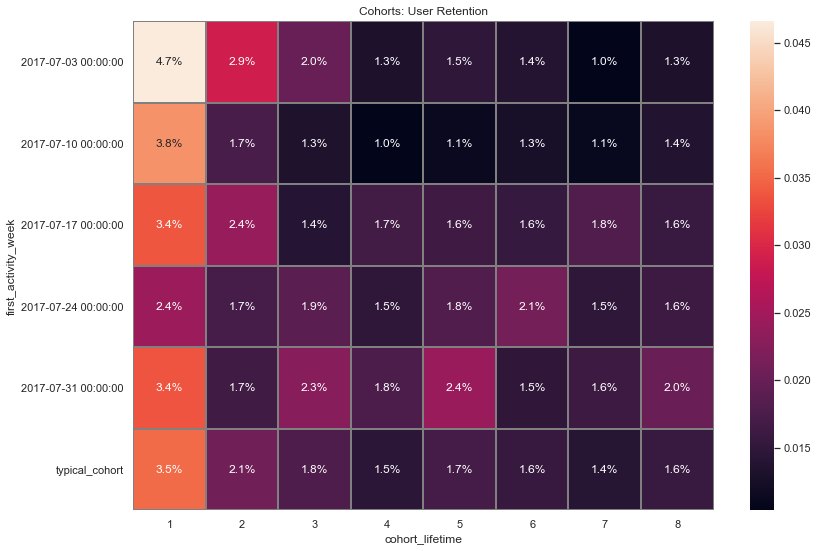

In [44]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot.iloc[:15, 1:15], annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

In [45]:
print('среднее значение Retention Rate за второй месяц жизни когорт: {:.1%}'.format(retention_pivot.loc['typical_cohort'].mean()))

среднее значение Retention Rate за второй месяц жизни когорт: 1.9%


In [46]:
def get_month(x): 
    return dt.datetime(x.year, x.month,1)
visits['session_month'] = visits['start_ts'].apply(get_month)
grouping = visits.groupby('uid')['session_month']
visits['cohort_month'] = grouping.transform('min')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_day,ASL,first_activity_date,activity_week,first_activity_week,cohort_lifetime,cohort_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,2017-12-01,1970-01-01 00:00:00.000000051,20,1080,2017-12-20,2017-12-18,2017-12-18,0,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2018-02-01,1970-01-01 00:00:00.000000008,19,1680,2018-02-19,2018-02-19,2018-02-19,0,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,2017-07-01,1970-01-01 00:00:00.000000026,1,0,2017-07-01,2017-06-26,2017-06-26,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,2018-05-01,1970-01-01 00:00:00.000000020,20,1440,2018-03-09,2018-05-14,2018-03-05,10,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,2017-12-01,1970-01-01 00:00:00.000000052,27,0,2017-12-27,2017-12-25,2017-12-25,0,2017-12-01


In [47]:
# используем функцию, которая получает нужный тип дат и считаем lifetime для когорт

def get_date (df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day 

session_year, session_month, session_day  = get_date(visits,'session_month')
cohort_year, cohort_month, cohort_day = get_date(visits,'cohort_month')

year_diff = session_year - cohort_year 
month_diff = session_month - cohort_month
day_diff = session_day - cohort_day

visits['cohort_lifetime'] = year_diff * 12 + month_diff + 1 # прибавим 1 месяц, чтобы когорты считались не с 0, а с 1


In [48]:
# считаем активных уникальных пользователей за месяц по когортам

grouping = visits.groupby(['cohort_month', 'cohort_lifetime'])
cohort_data = grouping['uid'].apply(pd.Series.nunique).reset_index()

cohort_counts = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_lifetime',
    values='uid')
cohort_counts 

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
cohort_size = cohort_counts.iloc[:, 0] # сохраняем в переменной число пользователей на первый месяц
retention = cohort_counts.divide(cohort_size, axis=0) # делим активных юзеров в каждый месяц на число юзеров на первый месяц
retention.fillna('').round(3) # округляем до 3 знаков, чтобы лучше видеть разницу, т.к. показатели слишком маленькие

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,,
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.03586,0.024186,0.022809,,,
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,,,,
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.0218,,,,,
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,,,,,,
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,,,,,,,
2018-02-01,1.0,0.05708,0.025454,0.020093,,,,,,,,


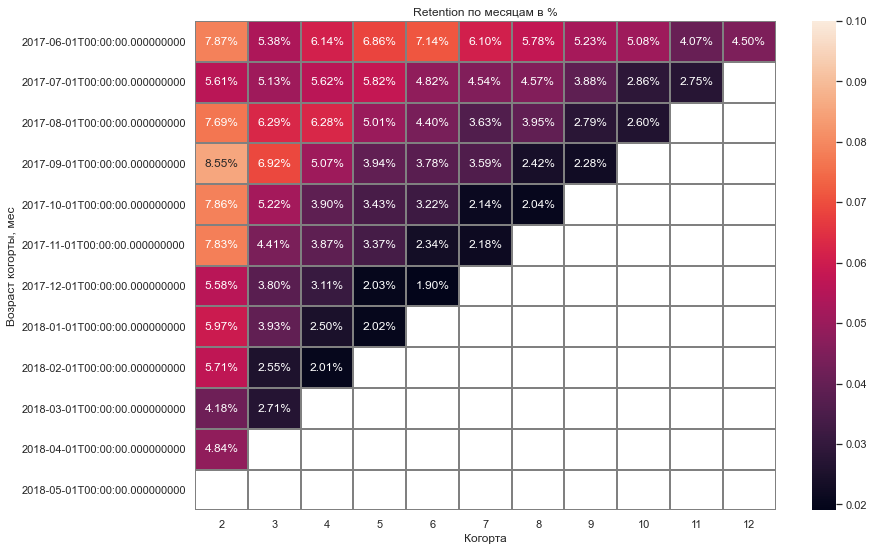

In [50]:
plt.figure(figsize=(13, 9))
sns.heatmap(retention.iloc[:12, 1:12], annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax=0.1);
plt.title('Retention по месяцам в %')
plt.xlabel('Когорта')
plt.ylabel('Возраст когорты, мес');

In [51]:
print('Retention на второй месяц — {:.1%}'.format(retention.mean(axis=0)[2]))

Retention на второй месяц — 6.5%


Изыучив фрейм visits, мы обнаружили, что 
- количество уникальных пользователей в день за весь период: 907
- количество уникальных пользователей в неделю за весь период: 5716
- количество уникальных пользователей в месяц за весь период: 23228
по метрикам DAU, WAU м MAU. 

Также мы обнаружили, что средняя продолжительность сессии или ASL равна 643 скундам, в то же время мода (чамая частовстречаюзаяся вечелична) ограничивается 60-ми секундами. 
Видим, что среднее кол-во сессий на клиента - одна в день, в день также заходят в среднем за весь период 5193 человека и совершают 5796 заказов. Максимальне количество сессий на клиента так же один раз в день на среднюю продолжительность 714 секунд. Это время различается в зависимости с какого утройства заходил пользователь - с телефона или с компьютера (548 секунд и 773 секугды соответсвенно - разница в практически два раза).

- Мы отвергли гипотезу о том, что не существует разницы между девайсами. Заставляет нас задуматься, что версия сайта для телефона менее удобна, чем для пользвателя компьютера.

- Мы так же обнаружили, что Retention Rate в первый месяц убывает по когортам с течением времени. Средний  Retention Rate за второй месяц - от 3 до 7 процентов и далее илет на спад. Мы видим, что наш сайт не очень популярный.

# Метрики электронной коммерции <a class="вывод" id="метрики_эл"></a>

# Время с момента первого посещения сайта до совершения покупки <a class="вывод" id="покупка"></a>

In [52]:
first_order_time = orders.groupby(['uid'])['order_data'].min().reset_index().rename({'order_data': 'first_order_time'}, axis=1)
first_session_time = visits.groupby(['uid'])['start_ts'].min().reset_index().rename({'start_ts': 'first_session_time'}, axis=1)
visit_order = first_order_time.merge(first_session_time)
visit_order.head()

,uid,first_order_time,first_session_time
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [53]:
visit_order['time_to_first_order'] = (visit_order['first_order_time'] - visit_order['first_session_time']).dt.seconds
print('cреднее время между первым посещением и покупкой {0} минут'.format(int((visit_order['time_to_first_order'].mean() / 60))))

cреднее время между первым посещением и покупкой 249 минут


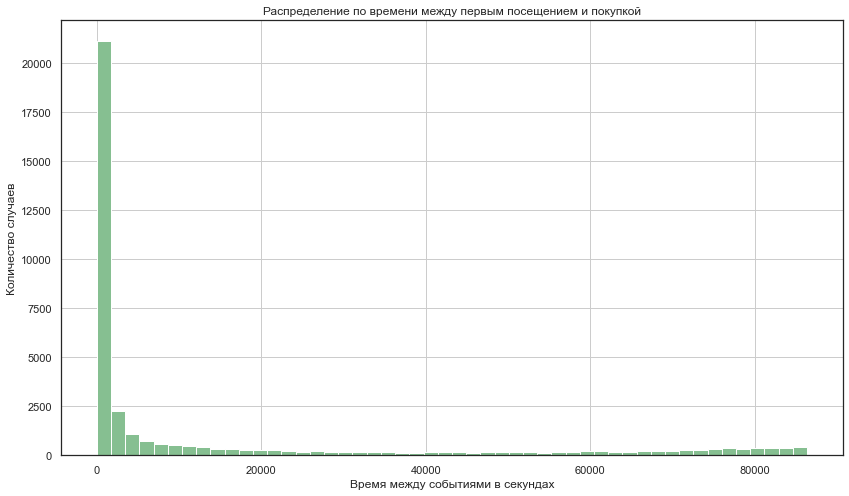

In [54]:
visit_order['time_to_first_order'].hist(bins=50, figsize=(14,8), color='#86bf91')
plt.title('Распределение по времени между первым посещением и покупкой')
plt.xlabel('Время между событиями в секундах')
plt.ylabel('Количество случаев');

Cнова геометрическое распределение. Оно далеко от нормального, берем моду качестве средней меры.

In [55]:
print('самое частое время между первым посещением и покупкой {0} минута'.format(visit_order['time_to_first_order'].mode()[0] / 60))

самое частое время между первым посещением и покупкой 1.0 минута


Среднее время между покупкой и первым посещением составляет 249 минут или чуть больше 4 часов. Однако на графике выше видно, что распределение геометрическое, поэтому проверив моду мы видим, что самое частое время между первым посещением и покупкой равно 1 минуте

# Среднее количество покупок на одного покупателя за 6 месяцев <a class="вывод" id="покупка_юзер"></a>

In [56]:
# используем функцию get_month из пункта по расчету retention
orders['order_month'] = orders['order_data'].apply(get_month)

avg_purchases = orders.groupby('order_month')['uid'].agg(['count', 'nunique'])
avg_purchases.columns = ['n_purchases', 'n_buyers']
avg_purchases['purchases_per_user'] = avg_purchases['n_purchases'] / avg_purchases['n_buyers']
display(avg_purchases.head())
print('среднее количество покупок на пользователя за 6 месяцев: {:.1f}'.format(avg_purchases['purchases_per_user'][:6].mean()))
print('среднее количество покупателей за 6 месяцев: {:.1f}'.format(avg_purchases['n_buyers'][:6].mean()))
print('среднее количество покупок за 6 месяцев: {:.1f}'.format(avg_purchases['n_purchases'][:6].mean()))

,n_purchases,n_buyers,purchases_per_user
order_month,,,
2017-06-01,2354,2023,1.163618
2017-07-01,2363,1984,1.191028
2017-08-01,1807,1472,1.227582
2017-09-01,3387,2750,1.231636
2017-10-01,5679,4675,1.214759


среднее количество покупок на пользователя за 6 месяцев: 1.2
среднее количество покупателей за 6 месяцев: 2908.5
среднее количество покупок за 6 месяцев: 3541.5


Среднее кол-во покупок = 1.2  ye


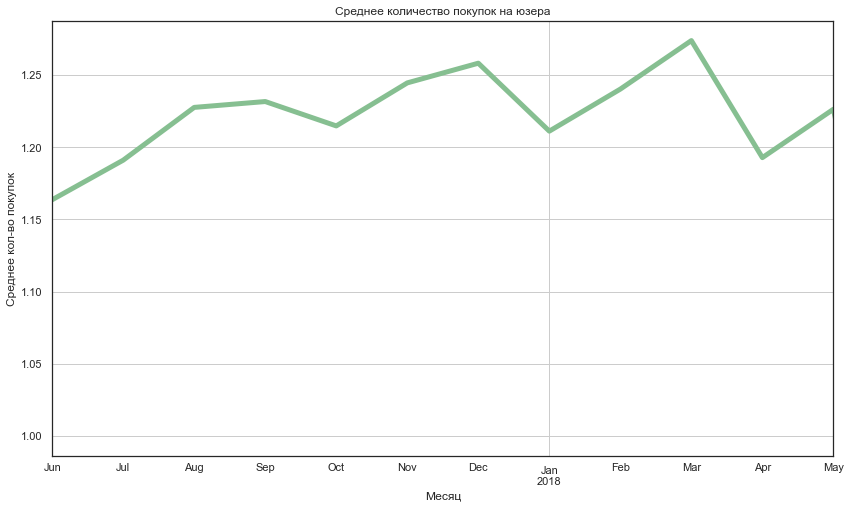

In [57]:
avg_purchases['purchases_per_user'].plot(title='Среднее количество покупок на юзера', legend=False, grid=True, figsize=(14,8), color='#86bf91',  linewidth = '5');
plt.xlabel('Месяц')
plt.ylabel('Среднее кол-во покупок')
plt.xlim(plt.xlim()[0], plt.xlim()[1]-1)
print('Среднее кол-во покупок = {:.1f}  ye'.format(avg_purchases['purchases_per_user'].mean()));

Мы нашли выручку по когорте "возрастом" поглода. Начиная с третьего месяца как и количество покупателей, на протяжении всего периода покупательная способность клиента идет вверх. Вероятно, клениты прибывают с наших рекламных источников. За полгода в среднем у нас было 2908 покупателей, которые купили на 3541 покупок. Своего максимума мы достигаем в последний месяц когорты - 4675 покупателя приобрели 5679 единиц товараза декабрь 2017. В среднем у нас одна покупка на одного покупателя за весь период

# Средний чек <a class="вывод" id="чек"></a>

In [58]:
# посчитаем количество покупок и общую сумму покупок по месяцам
avg_spend = orders.groupby('order_month').agg({'revenue': 'sum', 'uid': 'count'}).rename({'uid':'n_orders'}, axis=1)
avg_spend['avg_spend'] = (avg_spend['revenue'] / avg_spend['n_orders']).round(2)
avg_spend['avg_spend_percentage'] =(avg_spend['avg_spend'] / avg_spend['avg_spend'].sum()*100).round(2)
avg_spend = avg_spend[:12] #данные за июль крайне малы и нерелевантны
avg_spend

,revenue,n_orders,avg_spend,avg_spend_percentage
order_month,,,,
2017-06-01,9557.49,2354,4.06,6.45
2017-07-01,12539.47,2363,5.31,8.44
2017-08-01,8758.78,1807,4.85,7.71
2017-09-01,18345.51,3387,5.42,8.62
2017-10-01,27987.70,5679,4.93,7.84
2017-11-01,27069.93,5659,4.78,7.60
2017-12-01,36388.60,6218,5.85,9.30
2018-01-01,19417.13,4721,4.11,6.53
2018-02-01,25560.54,5281,4.84,7.69


Средний чек = 5.0  ye


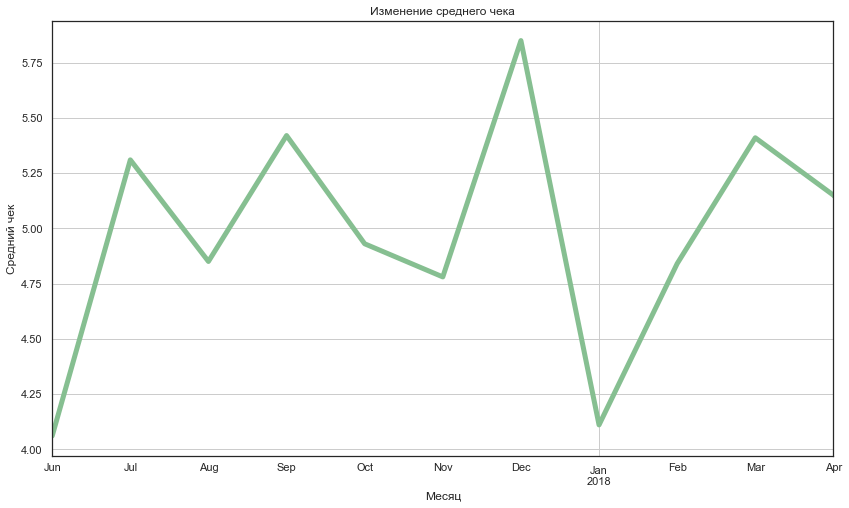

In [59]:
avg_spend.plot(figsize=(14,8), color='#86bf91',  linewidth = '5', y='avg_spend', grid=True, legend=False);
plt.title('Изменение среднего чека')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.xlim(plt.xlim()[0], plt.xlim()[1]-1)
print('Средний чек = {:.1f}  ye'.format(avg_spend['avg_spend'].mean()));

Мы нашли средний чек посетителя за все время - 5 уе на посетителя за все время. 
Видим резкий рост на конец ноября 2017 - о нем уже было упомянуто выше: веротяно, новогодние праздники. Средний чек на декабрь составляет 5.85 уе. Относительно средниз чеков за нояьрь и январь (4.78 и 4.11 соответсвенно). 9.3 процента от суммы чека за все время приходятся на декарь. Самую маленькую сумму чека мы наблюдаем в первый месяц - июнь 2017 и январь 2018. Вероятно, после новогодних праздников, клиенты решили отдохнуть.

# LTV на покупателя по когортам.  <a class="вывод" id="лтв"></a>

In [60]:
orders['order_data'].describe() 
#Первая покупка состоялась 1 июня 2017 года. Последняя — 31 июгя 2018-ого.

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: order_data, dtype: object

In [61]:
costs['dt'].describe() 
#Первая покупка состоялась 1 июня 2017 года. Последняя — 31 июгя 2018-ого.
#Диапазон дат расходов совпадает с датами заказов.

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

LTV удобно считать по когортам. Что для этого нужно:

- найти дату первой покупки каждого покупателя;
- вычислить число новых покупателей за каждую дату;
- добавить дату первой покупки в таблицу с заказами;
- сгруппировать таблицу и посчитать выручку.

In [62]:
first_orders = orders.groupby('uid').agg({'order_data': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
#first_otders['6-th_month'] = first_orders.apply(sixth_month, axis = 1) 
first_orders.first_order_month = first_orders['first_order_month'].dt.strftime('%Y-%m')

orders_ = pd.merge(first_orders, orders, on='uid')
orders_.head()

,uid,first_order_month,order_data,revenue,order_month
0,313578113262317,2018-01,2018-01-03 21:51:00,0.55,2018-01-01
1,1575281904278712,2017-06,2017-06-03 10:13:00,1.22,2017-06-01
2,1575281904278712,2017-06,2017-06-03 17:39:00,1.83,2017-06-01
3,2429014661409475,2017-10,2017-10-11 18:33:00,73.33,2017-10-01
4,2464366381792757,2018-01,2018-01-28 15:54:00,2.44,2018-01-01


In [63]:
ltv = orders_.groupby(['first_order_month']).agg({'revenue': 'sum', 'uid':'nunique'}).reset_index()
ltv.rename(columns = {'uid':'n_buyers'}, inplace=True)
display(ltv.head(2))
ltv['ltv'] = ltv['revenue'] / ltv['n_buyers']
ltv['ltv'] = ltv['ltv'].round(2)
display(ltv.head(2))

,first_order_month,revenue,n_buyers
0,2017-06,24031.69,2023
1,2017-07,16127.92,1923


,first_order_month,revenue,n_buyers,ltv
0,2017-06,24031.69,2023,11.88
1,2017-07,16127.92,1923,8.39


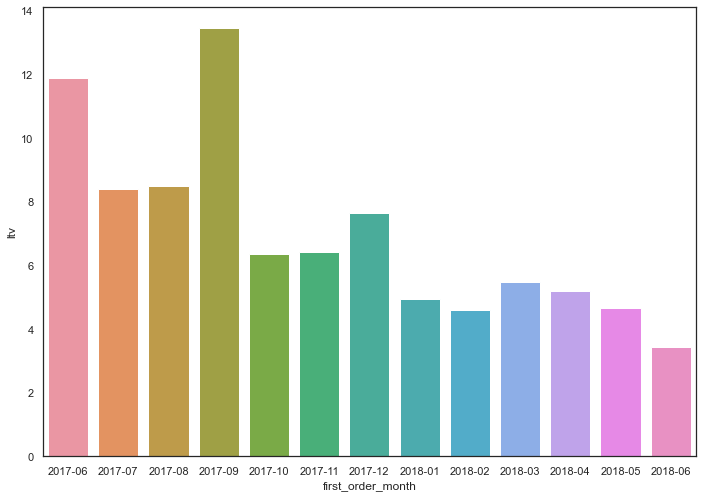

In [64]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data = ltv, x ="first_order_month", y = 'ltv')
plt.show()

In [65]:
#ltv_total = ltv['ltv'].mean()
#ltv_cumsum_total = np.cumsum(ltv['ltv']).mean()
#print(round(ltv_total, 2))
#print(round(ltv_cumsum_total, 2))

In [66]:
ltv_ = orders_.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
#ltv_.rename(columns = {'uid':'n_buyers'}, inplace=True)
report = pd.merge(ltv, ltv_, on='first_order_month')
report = report.drop('revenue_x', axis =1) 
report = report.rename(columns = {'revenue_y':'revenue'})

In [67]:
# так как маржинальность 100%, то валовая прибыль будет равна выручке, но для корректности я записал полную формулу
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'].astype('datetime64[M]')  - report['first_order_month'].astype('datetime64[M]') ) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,ltv,order_month,revenue,gp,age
0,2017-06,2023,4.724414,2017-06-01,9557.49,9557.49,0
1,2017-06,2023,0.485329,2017-07-01,981.82,981.82,1
2,2017-06,2023,0.437637,2017-08-01,885.34,885.34,2
3,2017-06,2023,0.954671,2017-09-01,1931.30,1931.30,3
4,2017-06,2023,1.022531,2017-10-01,2068.58,2068.58,4


In [68]:
report.groupby('first_order_month').agg({'ltv':'mean'})[:6]

,ltv
first_order_month,
2017-06,0.989936
2017-07,0.762441
2017-08,0.847172
2017-09,1.492803
2017-10,0.795030
2017-11,0.913606


In [69]:
report_6_months = report[(report['first_order_month'].astype('datetime64[M]')<='2017-11-01')]
output = report_6_months.pivot_table(
    index= 'first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round()

output.cumsum(axis=1, skipna=False)


output = report_6_months.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
ltv_output = output.cumsum(axis=1).round(2)
ltv_output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,


In [70]:
report_6_months = report_6_months.groupby('first_order_month').agg({'ltv':'sum'}).reset_index()

In [71]:
ltv_output.loc['avg_cohort'] = ltv_output.mean(axis=0)
print('Средний LTV на 6 месяц:', ltv_output.mean(axis=0)[5])

Средний LTV на 6 месяц: 8.023333333333333


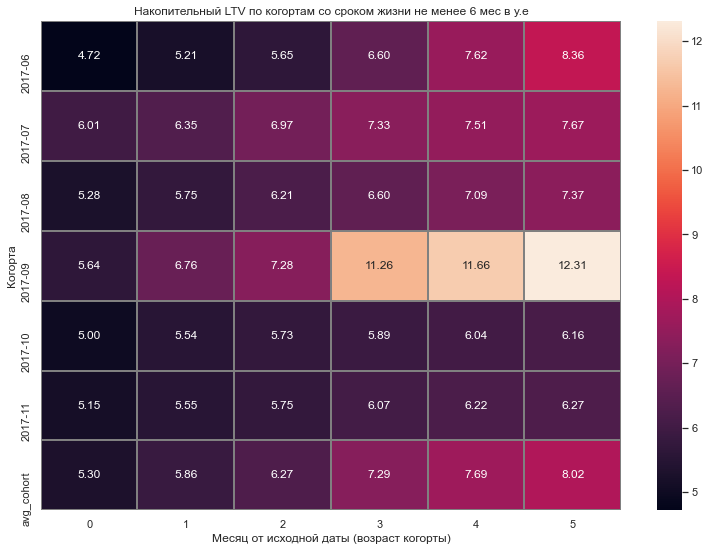

In [72]:
plt.figure(figsize=(13, 9))
sns.heatmap(ltv_output.iloc[0:7, 0:6], annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel('Месяц от исходной даты (возраст когорты)')
plt.ylabel('Когорта')
plt.title('Накопительный LTV по когортам со сроком жизни не менее 6 мес в у.е');

Мы нашли средний LTV за 6-ой месяц после первой покупки для когорт, "проживших"  больше полугода - он равен 8.02 за период. Была обнаружена странность в когорте за сентябрь 2017 по возрасту = 4 месяца: в среднем каждый клиент из этой когорты принес 11.26 уе, 11.66 уе и 12.31 уе за 4-ый, 5-ый и 6-ой месяцы жизни. Относительно всего периментра, где максимум доходит до 6.6 уе за 4-ый месяц, 7.09 уе за 5-ый месяц и 7.37 уе за 6-ой месяц, можно предположить, что дело в рекламе, направленной преимушественно на эту когорту. В те же месяцы других когорт подобных цифр не наблюдается. .
В целом наблюдается, что ltv растет со временм, а значит, что итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок, увеличивается.

- Мы соеденили таблицы посещений и покупок и нашли, сколько времени проходит с первого посещения сайта до первой покупки. В среднем уходит 16 дней на совершение первго заказка. Максимум прошло 334 дня (почти год) с момента решистрации до первой покупки

- Мы нашли выручку по когорте "возрастом" поглода. Начиная с третьего месяца как и количество покупателей, так и количество покупок - резко идет вверх. Значит, клениты прибывают с наших рекламныз источников или еще откуда-то. За полгода в среднем у нас было 2750 покупателей, которые купили на 3386 покупок за 18345 уе в среднем. Своего максимума мы достигаем в последний месяц когорты - 4942 покупателя приобрели 6218 единиц товара на 36388 уе за декабрь 2017.Минимум проданных товаров - 1472 за третий месяц на сумму 8758 уе.

- Мы нашли средний чек посетителя за все время - 15 уе на посетителя за все время. Мы видим невероятный всплеск в когорте "сентбярь 2017" за 4 месяц lifetime - 138.7 уе. Относительно других lifetime для этой когорты и других когорт - невероятное число, остется только полагать, что был какрй-то празлник или ошибка в системе.Но тем не менее мы наблюдаем, что 4-ый lifetime один из самых преуспеваюших - 31.5 уе - средний чек в этом периоде, можно сказать, что она - самая удачная для сайта. 

- Мы нашли средний LTV за 6 месяцев после первой покупки для когорт, "проживших" больше полугода: 8.02 за период. Была обнаружена странность в когорте за сентябрь 2017 по возрасту = 4: в среднем каждый клиент из этой когорты принес 0.4 уе за 4-ый месяц жизни.


# Маркетинговые метрики <a class="вывод" id="маркетинг"></a>

# Сумма всех расходов на маркетинг <a class="вывод" id="расходы"></a>

In [73]:
print('Сумма всех расходов на маркетинг: ',int(costs.costs.sum()), 'ye')

Сумма всех расходов на маркетинг:  329131 ye


In [74]:
costs['month'] = costs['dt'].apply(get_month)

In [75]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).sort_values('costs', ascending = False)
costs_by_source

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


In [76]:
# для рассмотрения изменений по каждому источнику по времени сделаем группировку по месяцу и источнику по расходам на маркетинг

monthly_costs_source = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}
        ).rename({'costs':'source_costs'}, axis=1).reset_index()

# чтобы даты были красивыми (без 00:00:00) приведем данные к формату date

monthly_costs_source['date_only'] = monthly_costs_source['month'].dt.date
monthly_costs_source

,month,source_id,source_costs,date_only
0,2017-06-01,1,1125.61,2017-06-01
1,2017-06-01,2,2427.38,2017-06-01
2,2017-06-01,3,7731.65,2017-06-01
3,2017-06-01,4,3514.80,2017-06-01
4,2017-06-01,5,2616.12,2017-06-01
...,...,...,...,...
79,2018-05-01,3,9411.42,2018-05-01
80,2018-05-01,4,4214.21,2018-05-01
81,2018-05-01,5,3669.56,2018-05-01
82,2018-05-01,9,362.17,2018-05-01


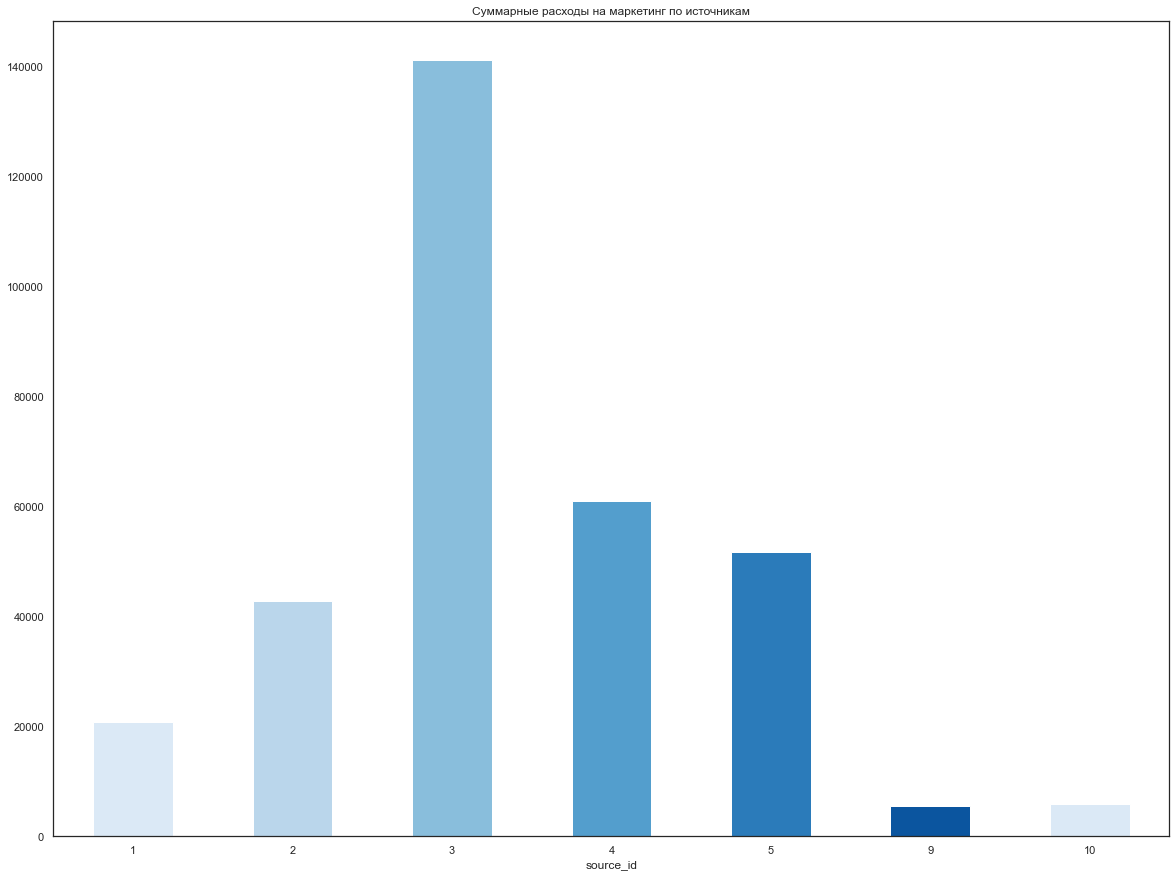

In [77]:
costs.groupby('source_id').costs.sum().plot.bar(title='Суммарные расходы на маркетинг по источникам', rot=0, figsize=(20,15), color = pal);

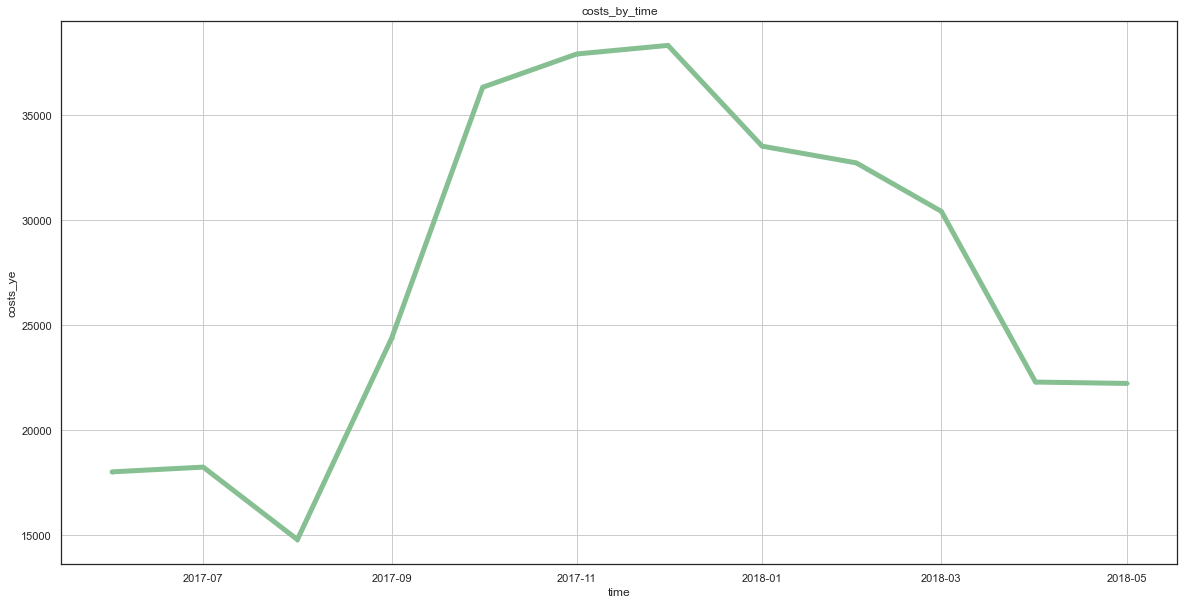

costs    27427.635
dtype: float64

In [78]:
df = costs.groupby('month').agg({'costs' : 'sum'})
plt_graph(df, 'costs_by_time', 'time', 'costs_ye')
df.mean()

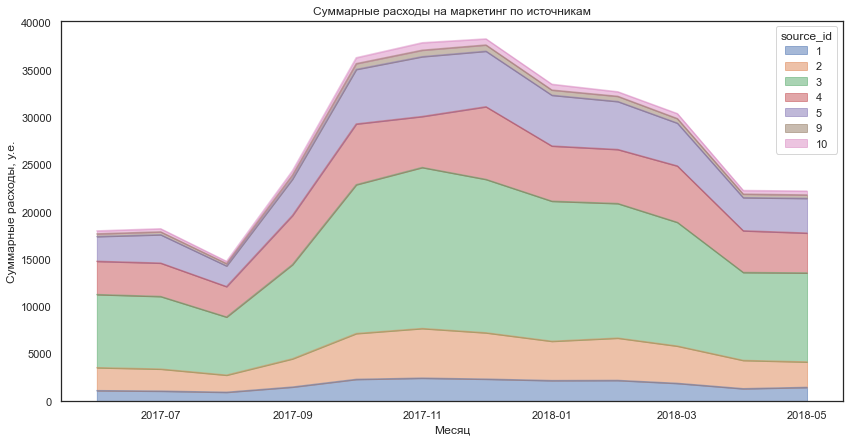

In [79]:
monthly_costs_source.pivot_table(
    index='date_only',
    columns='source_id',
    values='source_costs',
    aggfunc='sum'   
).plot.area(figsize=(14,7), title='Суммарные расходы на маркетинг по источникам', alpha = 0.5)
plt.xlabel('Месяц')
plt.ylabel('Суммарные расходы, у.е.');

Мы рассчитали САС для разных источников - выше всех у источника под номером 3, ниже всех у 9-ого и 10-ого. 

In [80]:
costs_by_source['percent'] = (costs_by_source['costs']/329131)*100
costs_by_source.sort_values('costs', ascending = False)

,costs,percent
source_id,,
3,141321.63,42.937806
4,61073.60,18.556016
5,51757.10,15.725380
2,42806.04,13.005776
1,20833.27,6.329781
10,5822.49,1.769049
9,5517.49,1.676381


Мы посчитали сумму расходов на марекинг для всех когорт. Наглядно видно, что больше всего было вложено в source_id под номером 3 - 141322 уе. Общая сумма затрат - 329132 уе. Меньше всего было вложено в источник под номером 9 -5518 уе

Заметно, что больше всего средств было потрачено c окьября по декабрь 2017-ого и идет наспад начиная с декаьря-января 2018-ого.

Динамика расходов близка к источнику под номером 1, 2, 3, 5 и 9 - у них у всех наблюдается резкий скачок внизу к январю, к августу и идет рост с августа до ноября.

# Рассчет среднего САС <a class="вывод" id="расходы_ист"></a>

In [81]:
monthly_costs = costs.groupby('month').agg({'costs': 'sum'})

In [82]:
report.first_order_month = pd.to_datetime(report.first_order_month)

In [83]:
report.first_order_month = pd.to_datetime(report.first_order_month)
report_new = pd.merge(
    report, monthly_costs, left_on='first_order_month', right_on='month'
)
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,ltv,order_month,revenue,gp,age,costs,cac
0,2017-06-01,2023,4.724414,2017-06-01,9557.49,9557.49,0,18015.0,8.905091
1,2017-06-01,2023,0.485329,2017-07-01,981.82,981.82,1,18015.0,8.905091
2,2017-06-01,2023,0.437637,2017-08-01,885.34,885.34,2,18015.0,8.905091
3,2017-06-01,2023,0.954671,2017-09-01,1931.30,1931.30,3,18015.0,8.905091
4,2017-06-01,2023,1.022531,2017-10-01,2068.58,2068.58,4,18015.0,8.905091


In [84]:
report_new.cac.mean()

9.319905176921111

In [85]:
cac = report_new.groupby('first_order_month').agg({'cac':'mean'}).reset_index()
cac

,first_order_month,cac
0,2017-06-01,8.905091
1,2017-07-01,9.485486
2,2017-08-01,10.796015
3,2017-09-01,9.441654
4,2017-10-01,8.369327
5,2017-11-01,9.288870
6,2017-12-01,8.741809
7,2018-01-01,9.937302
8,2018-02-01,8.962758
9,2018-03-01,8.608907


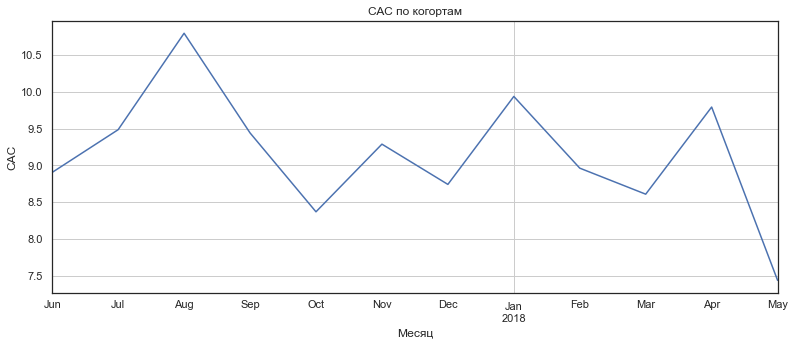

In [86]:
cac.plot(x='first_order_month', figsize=(13,5), grid=True, title='САС по когортам', legend=False);
plt.xlabel('Месяц')
plt.ylabel('CAC');

Мы рассчитали САС на одного покупателя за все время, он равен 9,32. Видим на графике резкий подьем к октябрю 2018, а затем спад к декабрю. На нижней таблице мы видимо, что между САС и LTV нет пересечений - САС значительно больше рой на протяжении всего периода. То есть вложения в привлечение покупателей не окупились, и у магазина остались деньги на прочие расходы.

In [87]:
visits_sources = visits.merge(first_session_time, left_on=['uid','start_ts'], right_on=['uid','first_session_time'])
visits_sources = visits_sources[['source_id', 'start_ts', 'uid', 'first_session_time', 'cohort_month']].copy()

full_visits_sources = orders.merge(visits_sources, on='uid', how='inner')

buyers_by_source = full_visits_sources.groupby('source_id').agg({'uid':'nunique'}
        ).rename(columns={'uid':'buyers'})
buyers_by_source

,buyers
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


In [88]:
# объединяем две таблицы с кол-вом покупателей и расходами по источникам 
cac_sources = buyers_by_source.join(costs_by_source)
# заполним 0 одного юзера из источника 7, который пришел бесплатно (на этот источник не тратились деньги)
cac_sources.fillna(0, inplace=True)
#cac_sources
cac_sources['cac'] = cac_sources['costs'] / cac_sources['buyers']
cac_sources.sort_values('cac', ascending=False)

,buyers,costs,percent,cac
source_id,,,,
3,10473,141321.63,42.937806,13.493901
2,3506,42806.04,13.005776,12.209367
5,6931,51757.10,15.725380,7.467479
1,2899,20833.27,6.329781,7.186364
4,10296,61073.60,18.556016,5.931779
9,1088,5517.49,1.676381,5.071222
10,1329,5822.49,1.769049,4.381106
7,1,0.00,0.000000,0.000000


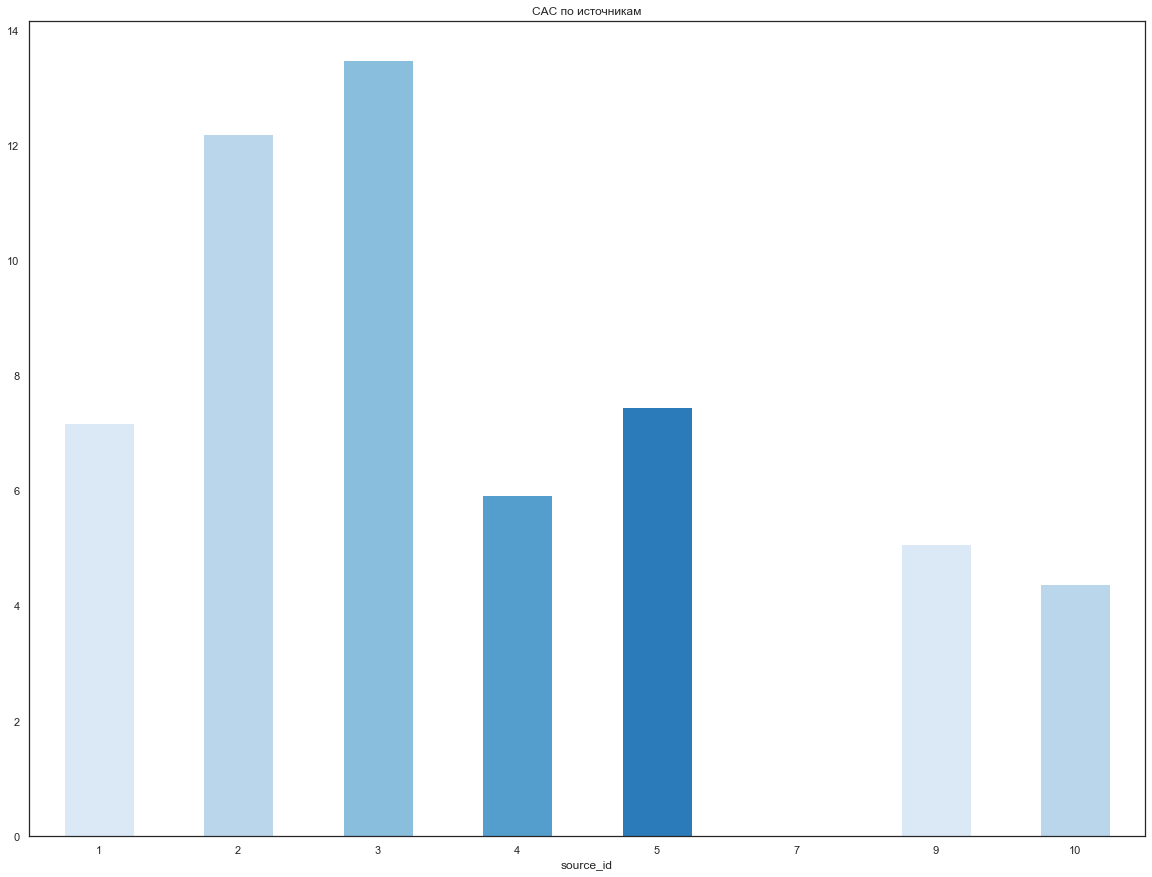

In [89]:
cac_sources.groupby('source_id').cac.mean().plot.bar(rot=0, figsize=(20,15), color = pal, title='CAC по источникам');

САС выше всех у источника под номером 3, немногим улчше у источника под номером 2 и номер 10 стоит на третьем месте.Делаю предпожение, что затраты на них не окупились, но чтобы проверить это точно, проверим РОМИ по источникам чуть ниже.

# ROMI по когортам. <a class="вывод" id="роми"></a>

In [90]:
#юерем когорты, которые старше погулгода, чтобы не ошибиться в показаниях
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)
report_new_six = report_new[report_new.first_order_month < '2017-12-01']
output_six = report_new_six.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_six.loc['mean'] = output.mean()
output_six.cumsum(axis=1).round(2).fillna('') 
#output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01 00:00:00,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01 00:00:00,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01 00:00:00,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,,
2017-09-01 00:00:00,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.4,1.42,,,
2017-10-01 00:00:00,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,,,,
2017-11-01 00:00:00,0.55,0.60,0.62,0.65,0.67,0.68,0.69,,,,,
mean,0.54,0.59,0.63,0.72,0.76,0.80,0.84,0.87,0.9,0.93,0.97,1.0


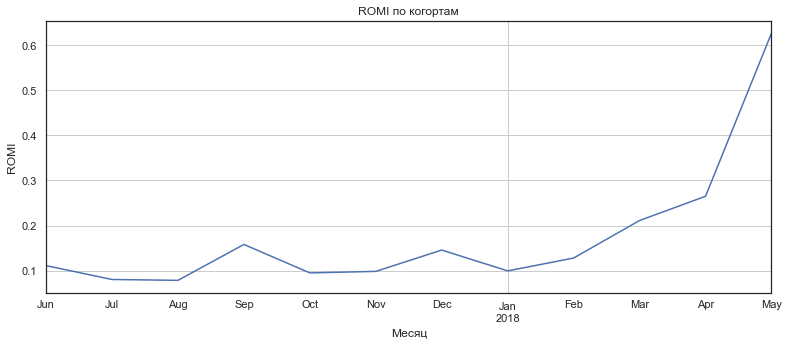

In [91]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi = report_new.groupby('first_order_month')['romi'].mean()
romi.plot(x='first_order_month', figsize=(13,5), grid=True, title='ROMI по когортам', legend=False);
plt.xlabel('Месяц')
plt.ylabel('ROMI');

Видим, что РОМИ за весь период поднимается начиная с января и резко роднимается с непосредствеено март, апрель и май.

In [92]:
output_six.loc['mean'].mean()

0.08340744657534015

In [93]:
output_six.cumsum(axis=1).mean(axis=0) 
#В среднем когорты окупаются к концу 11-ого месяца.

age
0     0.563478
1     0.621748
2     0.664711
3     0.771155
4     0.813000
5     0.848732
6     0.888021
7     0.952742
8     1.022720
9     0.956307
10    1.053787
11    1.167436
dtype: float64

# ROMI для источников по месяцам <a class="вывод" id="роми_ист"></a>

In [94]:
full_visits_sources

,order_data,revenue,uid,order_month,source_id,start_ts,first_session_time,cohort_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,2017-06-01 00:09:00,2017-06-01 00:09:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,2017-06-01 00:14:00,2017-06-01 00:14:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,2017-06-01 00:25:00,2017-06-01 00:25:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,2017-06-01 00:14:00,2017-06-01 00:14:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,2017-06-01 07:31:00,2017-06-01 07:31:00,2017-06-01
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,4,2018-05-31 09:11:00,2018-05-31 09:11:00,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,10,2018-05-31 23:05:00,2018-05-31 23:05:00,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,3,2018-05-31 23:52:00,2018-05-31 23:52:00,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,3,2017-10-23 12:32:00,2017-10-23 12:32:00,2017-10-01


In [95]:
# сгруппируем данные по выручке с источника
revenue_by_source = full_visits_sources.groupby(['source_id', 'cohort_month', 'order_month']).agg({'revenue':'sum'})
revenue_by_source

revenue
source_id cohort_month order_month         
1         2017-06-01   2017-06-01   1378.70
                       2017-07-01    662.73
                       2017-08-01    683.12
                       2017-09-01   1613.45
                       2017-10-01   1055.58
...                                     ...
10        2018-03-01   2018-04-01     22.42
                       2018-05-01      7.62
          2018-04-01   2018-04-01    237.44
                       2018-05-01     21.26
          2018-05-01   2018-05-01    364.34

[540 rows x 1 columns]

In [96]:
# объединим данные таблицы с кол-во покупателей и САС по источникам с новой таблицей с выручкой по источникам
full_sources = cac_sources.join(revenue_by_source).reset_index()

In [97]:
# посмотрим на выручку в абсолютных цифрах
full_sources.groupby(['source_id']).agg({'revenue':'sum', 'buyers':'max'}).round(2)

,revenue,buyers
source_id,,
1,31090.55,2899
2,46923.61,3506
3,54511.24,10473
4,56696.83,10296
5,52624.02,6931
7,1.22,1
9,5759.40,1088
10,4450.33,1329


In [98]:
# так как маржинальность 100%, то валовая прибыль будет равна выручке, но для корректности использую полную формулу
margin_rate = 1

full_sources['gp'] = full_sources['revenue'] * margin_rate
full_sources['age'] = (full_sources['order_month'] - full_sources['cohort_month']) / np.timedelta64(1, 'M') + 1
full_sources['age'] = full_sources['age'].round().astype('int')

full_sources.head() 

,source_id,cohort_month,order_month,buyers,costs,percent,cac,revenue,gp,age
0,1,2017-06-01,2017-06-01,2899,20833.27,6.329781,7.186364,1378.70,1378.70,1
1,1,2017-06-01,2017-07-01,2899,20833.27,6.329781,7.186364,662.73,662.73,2
2,1,2017-06-01,2017-08-01,2899,20833.27,6.329781,7.186364,683.12,683.12,3
3,1,2017-06-01,2017-09-01,2899,20833.27,6.329781,7.186364,1613.45,1613.45,4
4,1,2017-06-01,2017-10-01,2899,20833.27,6.329781,7.186364,1055.58,1055.58,5


In [99]:
# посчитаем LTV и посмотрим на накопительный LTV
full_sources['ltv'] = full_sources['gp'] / full_sources['buyers']
final_ltv_output = full_sources.pivot_table(index='source_id', columns='age', values='ltv', aggfunc='sum').round(2)

final_ltv_output = final_ltv_output.cumsum(axis=1).round(2)
final_ltv_output.fillna('')

age,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,
1,5.01,5.91,6.53,7.47,8.05,8.43,8.75,9.51,9.94,10.24,10.52,10.7
2,5.11,6.84,8.56,10.41,11.32,12.03,12.38,12.6,12.81,13.08,13.27,13.38
3,3.60,4.16,4.4,4.61,4.8,4.93,5.03,5.09,5.14,5.17,5.19,5.2
4,3.64,4.07,4.28,4.48,4.65,4.86,5.06,5.13,5.22,5.35,5.43,5.5
5,4.15,4.64,4.93,6.5,6.75,7.06,7.23,7.36,7.44,7.55,7.57,7.58
7,1.22,,,,,,,,,,,
9,2.18,2.76,3.29,3.76,4.18,4.39,4.64,4.82,5.07,5.22,5.27,5.28
10,2.67,2.9,3.0,3.06,3.19,3.25,3.3,3.32,3.32,3.33,3.34,3.35


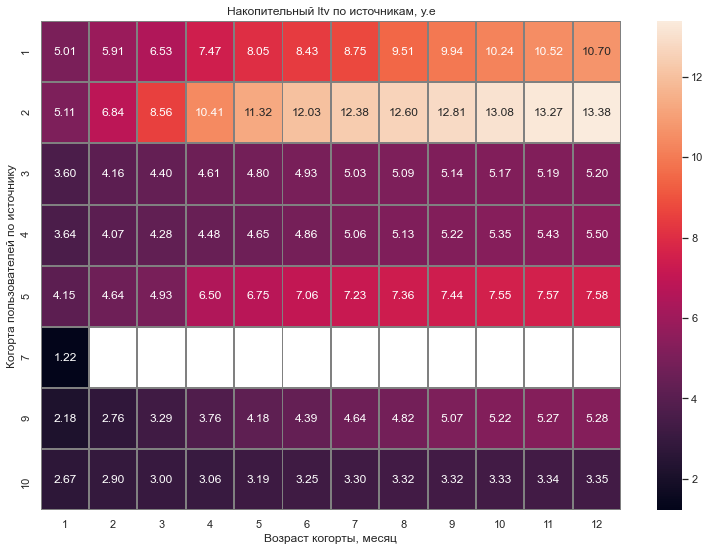

In [100]:
plt.figure(figsize=(13, 9))
sns.heatmap(final_ltv_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel('Возраст когорты, месяц')
plt.ylabel('Когорта пользователей по источнику')
plt.title('Накопительный ltv по источникам, у.е');

In [101]:
# сопоставляем LTV и САС по источникам
full_sources.groupby('source_id').agg({'ltv':'sum', 'cac':'mean'}).round(2)

,ltv,cac
source_id,,
1,10.72,7.19
2,13.38,12.21
3,5.20,13.49
4,5.51,5.93
5,7.59,7.47
7,1.22,0.00
9,5.29,5.07
10,3.35,4.38


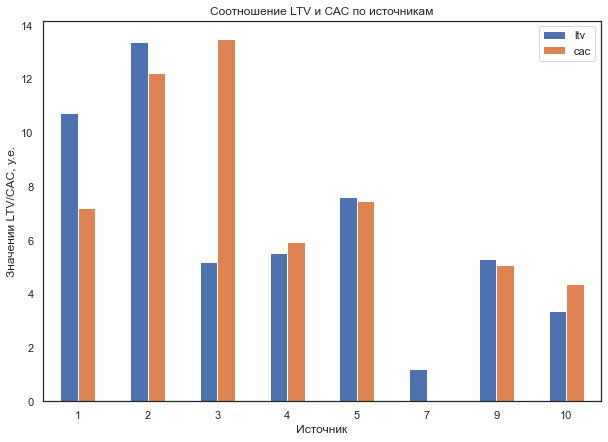

In [102]:
full_sources.groupby('source_id').agg({'ltv':'sum', 'cac':'mean'}).plot(kind='bar', figsize=(10,7), rot=0)
plt.xlabel('Источник')
plt.ylabel('Значении LTV/CAC, у.е.')
plt.title('Соотношение LTV и САС по источникам');

Видим, что ЛТВ  у источников номер 1, 2, 5 и 9 преимущественно выше, чем мх САС - значит, заатраты на них окупаются. Того же нельзя сказать об источнике 3, 4 и 10. Хуже всего на графике ведет себя ичтоник под номер 3 относительно затрат.

In [103]:
# посчитаем ROMI по источникам 
full_sources['romi'] = full_sources['ltv'] / full_sources['cac']
final_romi_output = full_sources.pivot_table(index='source_id', columns='age', values='romi', aggfunc='sum')
final_romi_output = final_romi_output.cumsum(axis=1).round(2).dropna() # dropna для удаления пустого источника 7
final_romi_output.fillna('')

age,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,
1,0.70,0.82,0.91,1.04,1.12,1.17,1.22,1.33,1.39,1.43,1.47,1.49
2,0.42,0.56,0.70,0.85,0.93,0.99,1.01,1.03,1.05,1.07,1.09,1.10
3,0.27,0.31,0.33,0.34,0.36,0.37,0.37,0.38,0.38,0.38,0.38,0.39
4,0.61,0.69,0.72,0.76,0.78,0.82,0.85,0.86,0.88,0.90,0.92,0.93
5,0.56,0.62,0.66,0.87,0.91,0.95,0.97,0.99,1.00,1.01,1.02,1.02
9,0.43,0.54,0.65,0.74,0.82,0.86,0.91,0.95,1.00,1.03,1.04,1.04
10,0.61,0.66,0.68,0.70,0.73,0.74,0.75,0.76,0.76,0.76,0.76,0.76


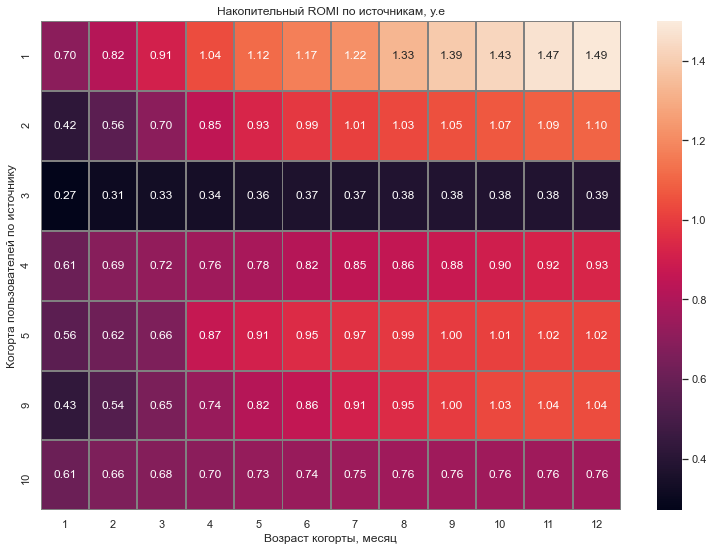

In [104]:
plt.figure(figsize=(13, 9))
sns.heatmap(final_romi_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax=1.5);
plt.xlabel('Возраст когорты, месяц')
plt.ylabel('Когорта пользователей по источнику')
plt.title('Накопительный ROMI по источникам, у.е');

In [105]:
print('Средний LTV по всем источникам на 6 месяц, у.е.:', final_ltv_output.mean(axis=0)[6].round(2))

Средний LTV по всем источникам на 6 месяц, у.е.: 6.42


In [106]:
print('Средний ROMI по всем источникам на 6 месяц, у.е.:', final_romi_output.mean(axis=0)[6].round(2))

Средний ROMI по всем источникам на 6 месяц, у.е.: 0.84


Лучший РОМИ наблюдается у источника под номером 1: он вызодит в плюс уже на четыертый месяц, несмотря на то, что средний ROMI по всем источникам на 6 месяц равен 0.84 уе, и только приближаетсяк окупаемости. Также, вероятно, из-запоказателей источника 3 (РОМИ которого за 12-ый месяц ниже РОМИ за первый месяц всез остальных источников), данные подвержены риску быть неточными.

to the viewer - честно говоря у меня возникли сложности с romi для источников. Вероятно, у меня ошибка в вычислениях или в со

# Выводы <a class="вывод" id="выводы"></a>

# Источники трафика, на которые маркетологам стоит делать упор. 
<a class="вывод" id="вывод_источник"></a>

Изучив данные Яндекс.Афиши с июня 2017 по конец мая 2018 года можно сказать, что хуже всех себя показывает источник под номером 3 - его окупаемость намного ниже вложений в источник - его LTV (lifetime value,итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок) составляет 5.2, в то время как CAC (customer acquisition cost — стоимость привлечения клиента) составляет 13.49, а РОМИ (это показатель рентабельности рекламных кампаний и в целом инвестиций в маркетинговую деятельность) покащывает, что источник назодится на посдежнем месте относительно прибыль/затраты.  В то же время, затраты на него самые высокие - 141321 уе за вест период. Напомним, что сумма всех расходов на маркетинг составляет 329131 ye, а значит, расходы на источник под номероем 3 составляют 43% от всех трат.

Лучше всез себя показывает источник под номером 1 - затраты на него составляют 20833 уе (6,3%), и приносит прибыль он уже начиная с 4-5 месяца.

По графику также видно, что источники под номерами 4 и 10 также практически не приносят прибыль. Источник 10 к концу периода (за 12 месяцев), так и не принес прибыль, а зактраты на него составили 5822 (1,8%) за все время. Источник 4 близится к получению прибыли, но также не приносит ее до конца периода. Зактраты на него составляют 61073,6 (18,6%), но его РОМИ один из худших. Хуже него только вышеупомянуьые источники номер 3 и 10.

Худшим является источник 3 — даже на 12 месяц его ROMI 0.39, что меньше чем у всех остальных источников в самый первый месяц

# Выводы,после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции <a class="вывод" id="вывод_маркетинг"></a>

Максимум уникальных пользователей на день приходится на 24 декабря 2017-ого. можно предположить, что дело в новогодних праздниках или кристмасе. Максимум уникальных пользователей на неделю приходится на лето 2018. 

Количество уникальных пользователей в день за весь период: 907, количество уникальных пользователей в неделю за весь период: 5716, количество уникальных пользователей в месяц за весь период: 23228.

Больше всего клиентов у нас было в ноябре, меньше всего летом. Вероятно, клиенты были в отпуске и были заняты другими делами.Максимальная активность за весь период прослеживаетсяпо дате 2017-11-24 - у нас было 3319 уникальных пользователей. По сравненпю с 907 в среднем - колосальная разница.

В день один пользователь в среднем проводит в приложении максимум 1 сессию. Не сказать, что продукт используется регулярно. В среднем на сайте обрабатывается 987 сессий и песещает 907 человек в день. Даже с максимум сессий в день - 4042 и 3319 пользователей сессия в день не превышает 1. Максимум сессий призодится на 24 декабря - можно предполодить, что дело в новогодниз праздниках или кристмасе

Среднее кол-во сессий на клиента - одна в день, в день также заходят в среднем за весь период 5193 человека и совершают 5796 заказов. Максимальне количество сессий на клиента так же один раз в день на среднюю продолжительность 714 секунд. Это время различается в зависимости с какого утройства заходил пользователь - с телефона или с компьютера (548 секунд и 773 секугды соответсвенно - разница в практически два раза).

Мы отвергли гипотезу о том, что не существует разницы между девайсами. Заставляет нас задуматься, что версия сайта для телефона менее удобна, чем для пользвателя компьютера.

Также было обнаружено, что Retention Rate в первый месяц убывает по когортам с течением времени. Средний Retention Rate за второй месяц - от 3 до 7 процентов и далее илет на спад. Мы видим, что наш сайт не очень популярный: от за период 6 месяцев Retention падает в среднем на 5% 

Среднее время между покупкой и первым посещением составляет 249 минут или чуть больше 4 часов. Однако на графике выше видно, что распределение геометрическое, поэтому проверив моду мы видим, что самое частое время между первым посещением и покупкой равно 1 минуте

Начиная с третьего месяца как и количество покупателей, на протяжении всего периода (6 мес) покупательная способность клиента повышается. Вероятно, клениты прибывают с наших рекламных источников. За полгода в среднем у нас было 2908 покупателей, которые купили на 3541 покупок. Своего максимума мы достигаем в последний месяц когорты - 4675 покупателя приобрели 5679 единиц товара за декабрь 2017. В среднем у нас одна покупка на одного покупателя за весь период

Мы нашли средний чек посетителя за все время - 5 уе на посетителя за все время. Видим резкий рост на конец ноября 2017 - о нем уже было упомянуто выше: веротяно, новогодние праздники. Средний чек на декабрь составляет 5.85 уе. Относительно средниз чеков за нояьрь и январь (4.78 и 4.11 соответсвенно). 9.3 процента от суммы чека за все время приходятся на декарь. Самую маленькую сумму чека мы наблюдаем в первый месяц - июнь 2017 и январь 2018. Вероятно, после новогодних праздников, клиенты решили отдохнуть.

Мы нашли средний LTV за 6-ой месяц после первой покупки для когорт, "проживших" больше полугода - он равен 8.02 за период. Была обнаружена странность в когорте за сентябрь 2017 по возрасту = 4 месяца: в среднем каждый клиент из этой когорты принес 11.26 уе, 11.66 уе и 12.31 уе за 4-ый, 5-ый и 6-ой месяцы жизни. Относительно всего периментра, где максимум доходит до 6.6 уе за 4-ый месяц, 7.09 уе за 5-ый месяц и 7.37 уе за 6-ой месяц, можно предположить, что дело в рекламе, направленной преимушественно на эту когорту. В те же месяцы других когорт подобных цифр не наблюдается. . В целом наблюдается, что ltv растет со временм, а значит, что итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок, увеличивается.

Мы посчитали сумму расходов на марекинг для всех когорт. Наглядно видно, что больше всего было вложено в source_id под номером 3 - 141322 уе. Общая сумма затрат - 329132 уе. Меньше всего было вложено в источник под номером 9 -5518 уе

Заметно, что больше всего средств было потрачено c окьября по декабрь 2017-ого и идет наспад начиная с декаьря-января 2018-ого.




# Итоги когортного анализа. Самые перспективные для компании когорты клиентов <a class="вывод" id="вывод_когорты"></a>

Когорты показали относительно равные показателии, однако стоит обратить внимание на сентябрьскую когорту — у нее самый высокий накопительный LTV и лучший показатель ROMI. Эта категория окупилась на 4 месяц, тогда как в среднем когорты окупаются на 9-10 месяце. Средний чек этой когорты за 6 месяцев составил чуть больше 12 у.е., что также является лучшим показателем среди всех: ни одна когорта даже по итогам максимального срока не достигла такого LTV. 

Вместе с этим перспективными также являются оставшиеся летние когорты 2017 года: июньская и сентябрьская котогрты: их LTV умеренно высокий (в сравнении с другими когортами) и превышает 7 у.е по итогам максимальной для каждой из них продолжительности жизни, а ROMI приближается к окупаемости.

* [Подготовка данных](#подготовка)
* [Продуктовые метрики](#метрики)
   * [Рассчет DAU, WAU и MAU](#дау)
   * [Сколько раз за день пользователи в среднем заходят на сайт](#визитс) 
   * [Продолжительность типичной пользовательской сессии](#продолжительность)
   * [Расчёт Retention Rate](#возврат)
* [Метрики электронной коммерции](#метрики_эл)
   * [Время с момента первого посещения сайта до совершения покупки](#покупка)
   * [Среднее количество покупок на одного покупателя за 6 месяцев](#покупка_юзер)
   * [LTV на покупателя по когортам. ](#лтв)
* [Маркетинговые метрики](#маркетинг)
   * [Сумма всех расходов на маркетинг](#расходы)
   * [Рассчет среднего САС](#расходы_ист)
   * [ROMI по когортам.](#роми)
   * [ROMI для источников по месяцам](#роми_ист)
* [Выводы](#выводы)
  * [Источники трафика, на которые маркетологам стоит делать упор. ](#вывод_источник)
  * [Выводы,после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции ](#вывод_маркетинг)
  * [Итоги когортного анализа. Самые перспективные для компании когорты клиентов¶ ](#вывод_когорты)